In [3]:

from esmvalcore.config import CFG
from esmvalcore.dataset import Dataset

CFG.load_from_file('/home/189/fc6164/esmValTool/config-fc-copy.yml')

### Datasets

In [4]:

obs = Dataset(
    short_name='tos',
    dataset='ERA-Interim',
    mip="Omon",
    project='OBS6',
    type='reanaly',
    timerange="19790101/20190101",
    tier=3)
# list(obs.from_files())
len(obs.files)

40

In [14]:

## model
var = Dataset(
    short_name='tos',
    mip='Omon',
    project='CMIP6',
    activity='CMIP',
    dataset='ACCESS-CM2',
    ensemble='r1i1p1f1',
    institute='*',
    grid='*',
    exp='historical',
    timerange='1979/2019',
    # derive='true'
)

var_noarea = var.copy()

var.add_supplementary(short_name='areacello', mip='Ofx')
var.find_files()
# list(var.from_files())[0].files
var.files,var.supplementaries[0].files


([LocalFile('/g/data/fs38/publications/CMIP6/CMIP/CSIRO-ARCCSS/ACCESS-CM2/historical/r1i1p1f1/Omon/tos/gn/v20191108/tos_Omon_ACCESS-CM2_historical_r1i1p1f1_gn_185001-201412.nc')],
 [LocalFile('/g/data/fs38/publications/CMIP6/CMIP/CSIRO-ARCCSS/ACCESS-CM2/historical/r1i1p1f1/Ofx/areacello/gn/v20191108/areacello_Ofx_ACCESS-CM2_historical_r1i1p1f1_gn.nc')])

Regridding:
model and observations regridded toward a generic 1°x1° grid (using cdms esmf linear method)

Steps (computation):

Niño3.4 SSTA
- seasonal cycle removed
- detrending (if applicable)
- smoothed with time running average
- spatial average

SSTA along the equator

- seasonal cycle removed
- detrending (if applicable)
- smoothed with time running average
- regridding (if applicable)
- meridional average
- smoothed with zonal running average

ENSO events
- detect December Niño3.4 SSTA < -0.75std (> 0.75std)

Diversity
- detect the zonal location of the maximum SSTA during all El Niño peak (December)
- detect the zonal location of the minimum SSTA during all La Niña peak (December)
- compute interquartile range (IQR) of the distribution of locations
- abs((model-ref)/ref)*100

In [6]:
import iris
from esmvalcore.preprocessor import (
                detrend, # dimension, method, 
                meridional_statistics, # 
                zonal_statistics,
                area_statistics,
                regrid, #esmf bilinear
                mask_landsea,
                anomalies,
                extract_month, 
                mask_inside_range,
                extract_region, # equatorial pacific #1 - 150°E-90°W, zonal 5°S-5°N average
                climate_statistics,# month mean, standard deviation
                rolling_window_statistics) 

import numpy as np
import iris.quickplot as qplt
import matplotlib.pyplot as plt
import iris.plot as iplt
import matplotlib.colors as mcolors
import cartopy.feature as cfeature
import cartopy.crs as ccrs


In [12]:

## 
def nino3_4ssta(cube):
    cube = extract_region(cube, 150, 270, -5, 5) #
    # cube = detrend(cube, dimension='time', method='linear') #? like anomalies?
    cube = regrid(cube, target_grid="1x1", scheme="linear")    
    cube = area_statistics(cube, 'mean') #Multi-dimensional coordinate not supported: 'latitude'

    cube = rolling_window_statistics(cube, coordinate='time', operator='mean', window_length=5)
    cube = anomalies(cube,period='monthly')
    return cube


def eq_ssta(cube):
    cube = extract_region(cube, 150, 270, -5, 5)
    # season cycle? detrend?
    cube = regrid(cube, target_grid="1x1", scheme="linear") #error regridding
    cube = rolling_window_statistics(cube, coordinate='time', operator='mean', window_length=5)
    cube = meridional_statistics(cube, 'mean')
    cube = anomalies(cube,period='monthly') #
    
    return cube

# ENSO events detect December Niño3.4 SSTA < -0.75std (> 0.75std)
# nino34ssta cube, get december, calc std_dev
def enso_events(cube):
    cube = extract_month(cube, 12)
    mean, std = cube.data.mean(), cube.data.std()
    range1, range2 = mean-0.75*std, mean + 0.75*std #separate for zonal
    events = mask_inside_range(cube, range1, range2)
    
    # build time with mask
    maskedTime = np.ma.masked_array(events.coord('time').points, mask=events.data.mask)
    
    # return years or mask to use?
    return events.data.mask, [events.coord('time').units.num2date(time).year for time in maskedTime.compressed()]

# Diversity - get zonal location of max and min
def diversity(ssta_cube, enso_mask): #2 masks
    # each enso year, max SSTA
    return #

# IQR and abs((model-ref)/ref)*100
def iqr(cube):
    data = cube.data.compressed()#get years?
    #calculate interquartile range 
    q3, q1 = np.percentile(data, [75 ,25])
    iqr = q3 - q1
    return iqr
    
def compute(obs_iqr, mod_iqr):
    return abs((mod_iqr-obs_iqr)/obs_iqr)*100

In [25]:
datasets = [var, obs]

#plot 1
process = {}
# for ds in datasets:
#     process[ds['dataset']] = eq_ssta(ds.load())


cb = eq_ssta(var.load())
print('max:', cb.data.max(),' min:',cb.data.min(),cb.units)

/g/data/xp65/public/apps/med_conda/envs/esmvaltool-0.4/lib/python3.11/site-packages/iris/cube.py:4620: IrisIgnoringBoundsWarning: The bounds of coordinate 'time' were ignored in the rolling window operation.
  warnings.warn(
/g/data/xp65/public/apps/med_conda/envs/esmvaltool-0.4/lib/python3.11/site-packages/iris/cube.py:4067: IrisUserWarning: Collapsing spatial coordinate 'latitude' without weighting
  warnings.warn(


max: 2.7856636  min: -3.0445347 degC


(432,) 29.322906 25.189402 27.312043366608798


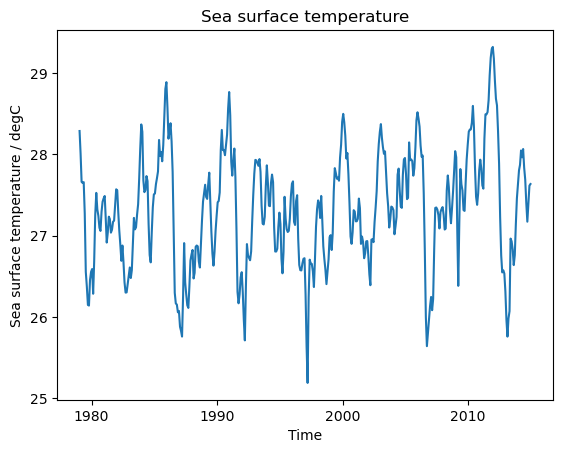

In [24]:
cube = var.load()
# cube_2 = var_noarea.load() #check supplementary
# cube_2

cube = extract_region(cube, 150, 270, -5, 5) 
cube = regrid(cube, target_grid="1x1", scheme="linear")    
cube = area_statistics(cube, 'mean')
print(cube.shape, cube.data.max(), cube.data.min(), cube.data.mean())
qplt.plot(cube)
# no regrid: (432,) 29.323744 25.20537 27.318201
# with regrid: (432,) 29.322906 25.189402 27.312043366608798

(432,) 29.322906 25.189402 27.312043366608798


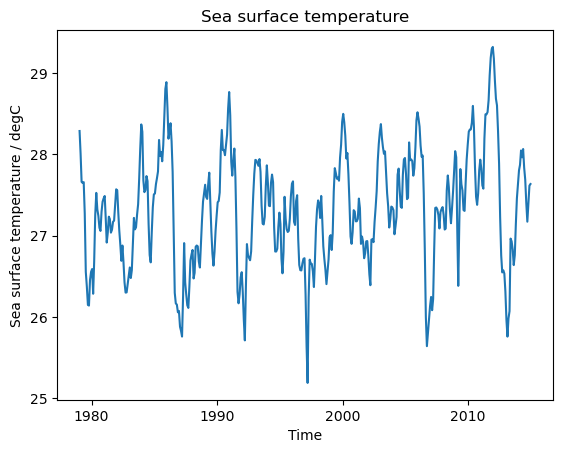

In [23]:
cube = var_noarea.load()

cube = extract_region(cube, 150, 270, -5, 5) 
cube = regrid(cube, target_grid="1x1", scheme="linear")    
cube = area_statistics(cube, 'mean')
print(cube.shape, cube.data.max(), cube.data.min(), cube.data.mean())
qplt.plot(cube)


max: 31.808344  min: 20.075079 degC
max: 30.000715  min: 24.097189 degC


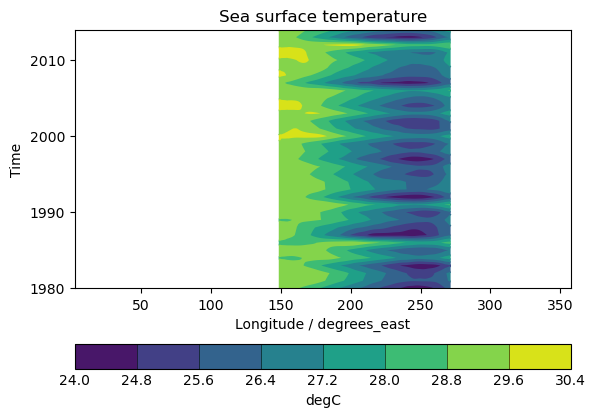

In [27]:
from esmvalcore.preprocessor.regrid_schemes import ESMPyLinear #not unstructured

print('max:', cb.data.max(),' min:',cb.data.min(),cb.units)
# anomalies(cb, period='month').data.max() #? max: 1.6647434  min: -1.5814272 degC

cube = regrid(cb, target_grid="1x1", scheme="linear")
# axis_statistics(cb, operator="mean", axis="y")
# area_statistics(cube, 'mean')
cube = meridional_statistics(cube, 'mean')
cube = extract_month(cube, 12)
print('max:', cube.data.max(),' min:',cube.data.min(),cube.units)
cb2 = rolling_window_statistics(cube, coordinate='longitude', operator='mean', window_length=5)
# qplt.contourf(cube)
qplt.contourf(cb2)

# collapse along time get MAX/MIN ..then IQR?
# collpase along lon, minmax ..IQR of lon ...retructure cube so that lon is data
# get events mask, get minSSTA loc...each year? 


# cb.collapsed('time',iris.analysis.MEAN).data
# cb.data.std()


/g/data/xp65/public/apps/med_conda/envs/esmvaltool-0.4/lib/python3.11/site-packages/iris/cube.py:4620: IrisIgnoringBoundsWarning: The bounds of coordinate 'time' were ignored in the rolling window operation.
  warnings.warn(


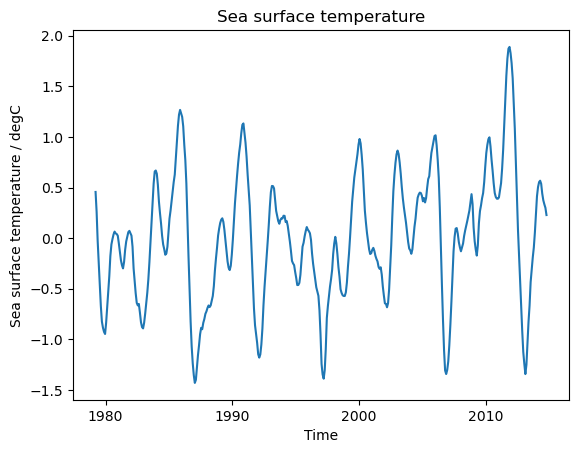

In [13]:
qplt.plot(nino3_4ssta(var.load()))